# Chapter 6

In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

from scipy import stats
from scipy.optimize import curve_fit

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
%config Inline.figure_format = 'retina'
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz
np.random.seed(0)

#### Code 6.1

In [3]:
np.random.seed(3)
N = 200  # num grant proposals
p = 0.1  # proportion to select
# uncorrelated newsworthiness and trustworthiness
nw = np.random.normal(size=N)
tw = np.random.normal(size=N)
# select top 10% of combined scores
s = nw + tw  # total score
q = np.quantile(s, 1 - p)  # top 10% threshold
selected = s >= q
cor = np.corrcoef(tw[selected], nw[selected])
cor

array([[ 1.        , -0.74495204],
       [-0.74495204,  1.        ]])

Text(0, 0.5, 'trustworthiness')

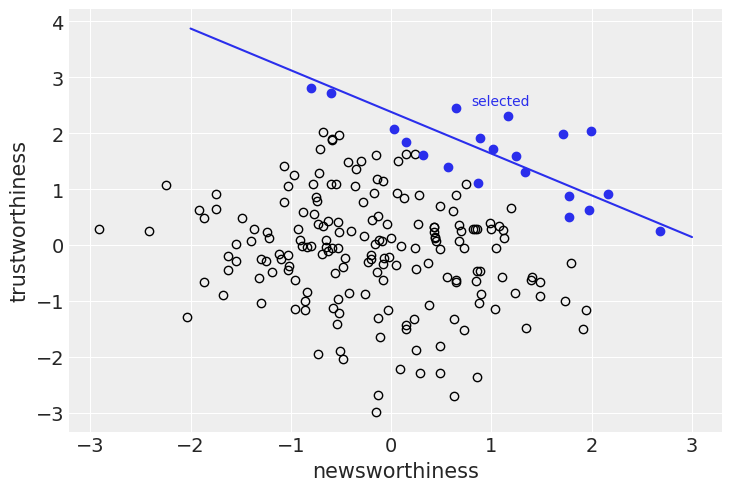

In [4]:
# Figure 6.1
plt.scatter(nw[~selected], tw[~selected], lw=1, edgecolor="k", color=(0, 0, 0, 0))
plt.scatter(nw[selected], tw[selected], color="C0")
plt.text(0.8, 2.5, "selected", color="C0")

# correlation line
xn = np.array([-2, 3])
plt.plot(xn, tw[selected].mean() + cor[0, 1] * (xn - nw[selected].mean()))

plt.xlabel("newsworthiness")
plt.ylabel("trustworthiness")

#### Code 6.2

In [5]:
N = 100  # number of individuals
height = np.random.normal(10, 2, N)  # sim total height of each
leg_prop = np.random.uniform(0.4, 0.5, N)  # leg as proportion of height
leg_left = leg_prop * height + np.random.normal(0, 0.02, N)  # sim left leg as proportion + error
leg_right = leg_prop * height + np.random.normal(0, 0.02, N)  # sim right leg as proportion + error

d = pd.DataFrame(
    np.vstack([height, leg_left, leg_right]).T,
    columns=["height", "leg_left", "leg_right"],
)  # combine into data frame

d.head()

,height,leg_left,leg_right
0,10.178107,4.206429,4.158048
1,11.557794,4.769875,4.825845
2,12.529290,5.543952,5.529080
3,8.238977,3.853735,3.801846
4,10.472811,4.333044,4.290579


#### Code 6.3

In [6]:
with pm.Model() as m_6_1:
    a = pm.Normal("a", 10, 100)
    bl = pm.Normal("bl", 2, 10)
    br = pm.Normal("br", 2, 10)

    mu = a + bl * d["leg_left"].values + br * d["leg_right"].values
    sigma = pm.Exponential("sigma", 1)

    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d["height"].values)

    idata_6_1 = pm.sample(draws=100, tune=100)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bl, br, sigma]


Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 46 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [7]:
az.summary(idata_6_1, round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.00,0.31,0.52,1.47,0.02,0.01,269.67,155.59,1.01
bl,-1.77,2.04,-5.66,0.86,0.21,0.15,91.65,116.41,1.03
br,3.79,2.03,0.31,6.83,0.21,0.15,89.49,122.65,1.03
sigma,0.65,0.05,0.57,0.71,0.00,0.00,388.50,242.59,1.02


#### Code 6.4

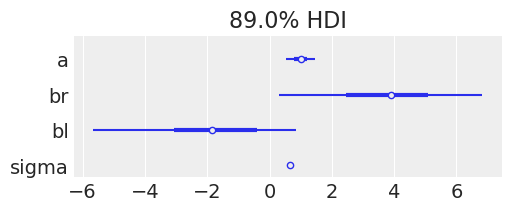

In [8]:
_ = az.plot_forest(idata_6_1, var_names=["a", "br", "bl", "sigma"], combined=True, figsize=[5, 2])

#### Code 6.5 & 6.6

Because we used MCMC (c.f. `quap`), the posterior samples are already in `m_6_1_trace`.

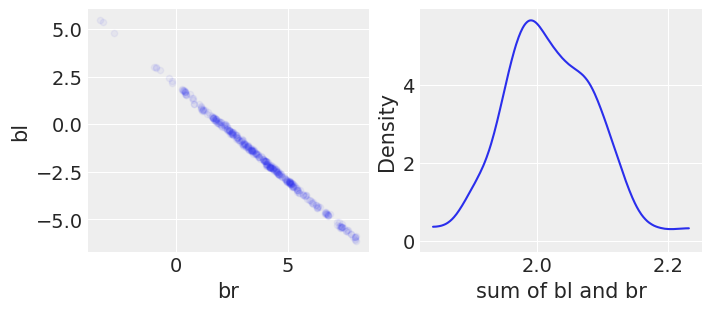

In [9]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=[7, 3])

br_post = idata_6_1["posterior"]["br"].values
bl_post = idata_6_1["posterior"]["bl"].values

# code 6.5
ax1.scatter(br_post, bl_post, alpha=0.05, s=20)
ax1.set_xlabel("br")
ax1.set_ylabel("bl")

# code 6.6
az.plot_kde(br_post + bl_post, ax=ax2)
ax2.set_ylabel("Density")
ax2.set_xlabel("sum of bl and br");

#### Code 6.7

In [10]:
with pm.Model() as m_6_2:
    a = pm.Normal("a", 10, 100)
    bl = pm.Normal("bl", 2, 10)

    mu = a + bl * d.leg_left.values
    sigma = pm.Exponential("sigma", 1)

    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d.height.values)

    idata_6_2 = pm.sample()

az.summary(idata_6_2, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bl, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.91,0.33,0.38,1.46,0.01,0.01,1219.67,1388.81,1.0
bl,2.04,0.07,1.93,2.16,0.00,0.00,1227.55,1434.52,1.0
sigma,0.65,0.05,0.58,0.73,0.00,0.00,1971.54,1402.56,1.0


#### Code 6.8

In [11]:
d = pd.read_csv("Data/milk.csv", sep=";")


def standardise(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()


d.loc[:, "K"] = standardise(d["kcal.per.g"])
d.loc[:, "F"] = standardise(d["perc.fat"])
d.loc[:, "L"] = standardise(d["perc.lactose"])

d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc,K,F,L
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16,-0.940041,-1.217243,1.307262
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN,-0.816126,-1.030355,1.011285
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN,-1.125913,-1.391531,1.382679
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN,-1.001998,-1.335535,1.586874
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN,-0.258511,-0.469693,0.257115


#### Code 6.9

In [12]:
# kcal.per.g regressed on perc.fat
with pm.Model() as m_6_3:
    a = pm.Normal("a", 0, 0.2)
    bF = pm.Normal("bF", 0, 0.5)

    mu = a + bF * d.F.values
    sigma = pm.Exponential("sigma", 1)

    K = pm.Normal("K", mu, sigma, observed=d.K.values)

    idata_6_3 = pm.sample()

az.summary(idata_6_3, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bF, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.00,0.08,-0.13,0.13,0.0,0.0,4090.86,2801.08,1.0
bF,0.86,0.09,0.71,1.01,0.0,0.0,5282.12,3126.10,1.0
sigma,0.49,0.07,0.38,0.59,0.0,0.0,4450.81,3163.96,1.0


In [13]:
# kcal.per.g regressed on perc.lactose
with pm.Model() as m_6_4:
    a = pm.Normal("a", 0, 0.2)
    bL = pm.Normal("bF", 0, 0.5)

    mu = a + bL * d.L.values
    sigma = pm.Exponential("sigma", 1)

    K = pm.Normal("K", mu, sigma, observed=d.K.values)

    idata_6_4 = pm.sample()

az.summary(idata_6_4, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bF, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.00,0.07,-0.12,0.11,0.0,0.0,4233.87,2983.64,1.0
bF,-0.90,0.08,-1.02,-0.77,0.0,0.0,5514.26,3245.40,1.0
sigma,0.41,0.06,0.33,0.50,0.0,0.0,3833.38,2483.97,1.0


#### Code 6.10

In [14]:
with pm.Model() as m_6_5:
    a = pm.Normal("a", 0, 0.2)
    bF = pm.Normal("bF", 0, 0.5)
    bL = pm.Normal("bL", 0, 0.5)

    mu = a + bF * d.F.values + bL * d.L.values
    sigma = pm.Exponential("sigma", 1)

    K = pm.Normal("K", mu, sigma, observed=d.K.values)

    idata_6_5 = pm.sample()

az.summary(idata_6_5, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bF, bL, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.00,0.07,-0.11,0.12,0.0,0.0,2390.49,1979.54,1.01
bF,0.25,0.19,-0.03,0.57,0.0,0.0,1867.66,1904.40,1.00
bL,-0.67,0.19,-0.96,-0.37,0.0,0.0,1871.78,1981.08,1.00
sigma,0.42,0.06,0.32,0.50,0.0,0.0,2420.33,2390.65,1.00


#### Code 6.11

c:\Users\mason\AppData\Local\Continuum\anaconda3\envs\stat-rethink2-pymc\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


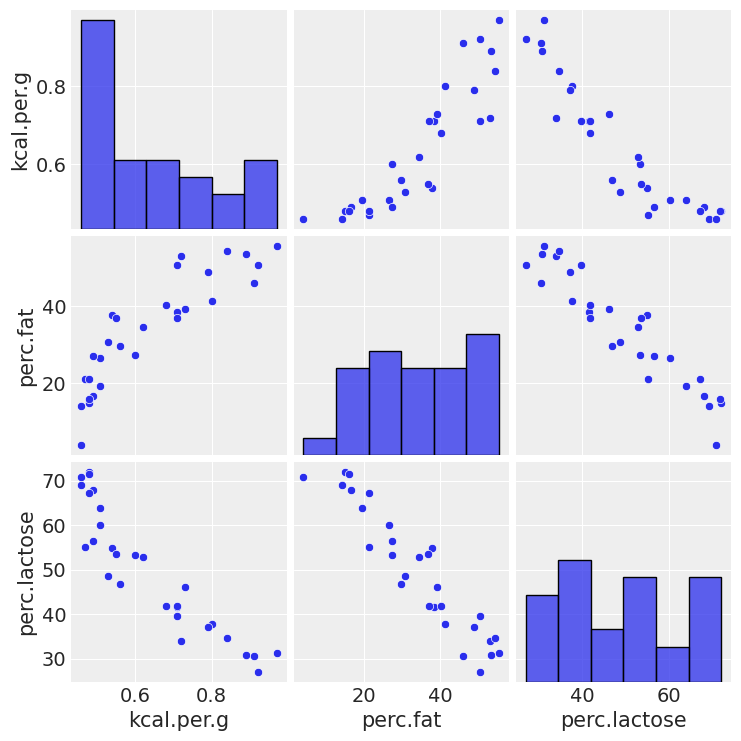

In [15]:
sns.pairplot(d.loc[:, ["kcal.per.g", "perc.fat", "perc.lactose"]]);

#### Code 6.12

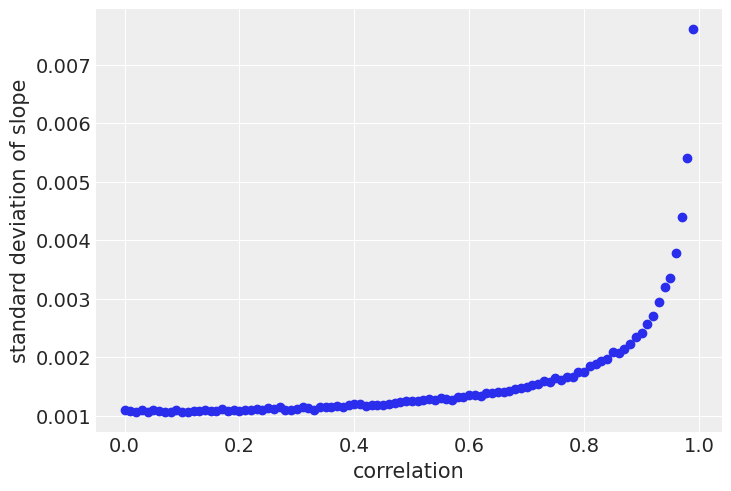

In [16]:
def mv(x, a, b, c):
    return a + x[0] * b + x[1] * c


def sim_coll(r=0.9):
    x = np.random.normal(loc=r * d["perc.fat"], scale=np.sqrt((1 - r**2) * np.var(d["perc.fat"])))
    _, cov = curve_fit(mv, (d["perc.fat"], x), d["kcal.per.g"])
    return np.sqrt(np.diag(cov))[-1]


def rep_sim_coll(r=0.9, n=100):
    return np.mean([sim_coll(r) for i in range(n)])


r_seq = np.arange(0, 1, 0.01)
stdev = list(map(rep_sim_coll, r_seq))

plt.scatter(r_seq, stdev)
plt.xlabel("correlation")
plt.ylabel("standard deviation of slope");

#### Code 6.13

In [17]:
# number of plants
N = 100
# simulate initial heights
h0 = np.random.normal(10, 2, N)
# assign treatments and simulate fungus and growth
treatment = np.repeat([0, 1], N / 2)
fungus = np.random.binomial(n=1, p=0.5 - treatment * 0.4, size=N)
h1 = h0 + np.random.normal(5 - 3 * fungus, size=N)
# compose a clean data frame
d = pd.DataFrame.from_dict({"h0": h0, "h1": h1, "treatment": treatment, "fungus": fungus})

az.summary(d.to_dict(orient="list"), kind="stats", round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%
h0,10.19,1.95,7.15,12.93
h1,14.28,2.41,10.78,18.26
treatment,0.50,0.50,0.00,1.00
fungus,0.31,0.46,0.00,1.00


#### Code 6.14

In [18]:
sim_p = np.random.lognormal(0, 0.25, int(1e4))

az.summary(sim_p, kind="stats", round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%
x,1.03,0.26,0.64,1.42


#### Code 6.15

In [19]:
with pm.Model() as m_6_6:
    p = pm.Lognormal("p", 0, 0.25)

    mu = p * d.h0.values
    sigma = pm.Exponential("sigma", 1)

    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=d.h1.values)

    idata_6_6 = pm.sample()

az.summary(idata_6_6, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,1.38,0.02,1.35,1.41,0.0,0.0,3952.28,2848.33,1.0
sigma,1.95,0.14,1.72,2.15,0.0,0.0,3399.66,2628.19,1.0


#### Code 6.16

In [20]:
with pm.Model() as m_6_7:
    a = pm.Normal("a", 0, 0.2)
    bt = pm.Normal("bt", 0, 0.5)
    bf = pm.Normal("bf", 0, 0.5)

    p = a + bt * d.treatment.values + bf * d.fungus.values

    mu = p * d.h0.values
    sigma = pm.Exponential("sigma", 1)

    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=d.h1.values)

    idata_6_7 = pm.sample()

az.summary(idata_6_7, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bt, bf, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 53 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.45,0.02,1.42,1.49,0.0,0.0,2143.13,2252.34,1.0
bt,0.04,0.03,-0.01,0.08,0.0,0.0,2435.26,2774.04,1.0
bf,-0.27,0.03,-0.32,-0.23,0.0,0.0,2446.64,2476.98,1.0
sigma,1.30,0.10,1.14,1.44,0.0,0.0,2946.64,2302.50,1.0


#### Code 6.17

In [21]:
with pm.Model() as m_6_8:
    a = pm.Normal("a", 0, 0.2)
    bt = pm.Normal("bt", 0, 0.5)

    p = a + bt * d.treatment.values

    mu = p * d.h0.values
    sigma = pm.Exponential("sigma", 1)

    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=d.h1.values)

    idata_6_8 = pm.sample()

az.summary(idata_6_8, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bt, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.30,0.03,1.26,1.34,0.0,0.0,2397.74,2289.01,1.0
bt,0.14,0.04,0.08,0.19,0.0,0.0,2356.29,2638.06,1.0
sigma,1.86,0.13,1.63,2.06,0.0,0.0,2483.32,2133.28,1.0


#### Code 6.18

Using [`causalgraphicalmodels`](https://github.com/ijmbarr/causalgraphicalmodels) for graph drawing and analysis instead of `dagitty`, following the example of [ksachdeva's Tensorflow version of Rethinking](https://ksachdeva.github.io/rethinking-tensorflow-probability/)

c:\Users\mason\AppData\Local\Continuum\anaconda3\envs\stat-rethink2-pymc\Lib\site-packages\IPython\core\events.py:82: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
c:\Users\mason\AppData\Local\Continuum\anaconda3\envs\stat-rethink2-pymc\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


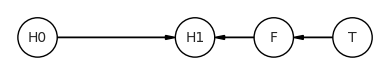

In [22]:
import daft

from causalgraphicalmodels import CausalGraphicalModel


def draw_dag(dag, coordinates):
    pgm = daft.PGM()
    for node in dag.dag.nodes:
        pgm.add_node(node, node, *coordinates[node])
    for edge in dag.dag.edges:
        pgm.add_edge(*edge)
    pgm.render()
    plt.gca().invert_yaxis()


plant_dag = CausalGraphicalModel(
    nodes=["H0", "H1", "F", "T"], edges=[("H0", "H1"), ("F", "H1"), ("T", "F")]
)
coordinates = {"H0": (0, 0), "T": (4, 0), "F": (3, 0), "H1": (2, 0)}

draw_dag(plant_dag, coordinates)

#### Code 6.19

Credit [ksachdeva](https://ksachdeva.github.io/rethinking-tensorflow-probability/)

In [23]:
all_independencies = plant_dag.get_all_independence_relationships()
for s in all_independencies:
    if all(
        t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
        for t in all_independencies
        if t != s
    ):
        print(s)

('T', 'H0', set())
('T', 'H1', {'F'})
('H0', 'F', set())


#### Code 6.20

In [24]:
N = 1000
h0 = np.random.normal(10, 2, N)
treatment = np.repeat([0, 1], N / 2)
M = np.random.binomial(1, 0.5, size=N)  # assumed probability 0.5 here, as not given in book
fungus = np.random.binomial(n=1, p=0.5 - treatment * 0.4 + 0.4 * M, size=N)
h1 = h0 + np.random.normal(5 + 3 * M, size=N)
d = pd.DataFrame.from_dict({"h0": h0, "h1": h1, "treatment": treatment, "fungus": fungus})

az.summary(d.to_dict(orient="list"), kind="stats", round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%
h0,10.14,2.01,6.92,13.37
h1,16.63,2.70,11.99,20.78
treatment,0.50,0.50,0.00,1.00
fungus,0.52,0.50,0.00,1.00


Re-run m_6_6 and m_6_7 on this dataset

#### Code 6.21

Including a python implementation of the sim_happiness function

In [25]:
def inv_logit(x):
    return np.exp(x) / (1 + np.exp(x))


def sim_happiness(N_years=100, seed=1234):
    np.random.seed(seed)

    popn = pd.DataFrame(np.zeros((20 * 65, 3)), columns=["age", "happiness", "married"])
    popn.loc[:, "age"] = np.repeat(np.arange(65), 20)
    popn.loc[:, "happiness"] = np.repeat(np.linspace(-2, 2, 20), 65)
    popn.loc[:, "married"] = np.array(popn.loc[:, "married"].values, dtype="bool")

    for i in range(N_years):
        # age population
        popn.loc[:, "age"] += 1
        # replace old folk with new folk
        ind = popn.age == 65
        popn.loc[ind, "age"] = 0
        popn.loc[ind, "married"] = False
        popn.loc[ind, "happiness"] = np.linspace(-2, 2, 20)

        # do the work
        elligible = (popn.married == 0) & (popn.age >= 18)
        marry = np.random.binomial(1, inv_logit(popn.loc[elligible, "happiness"] - 4)) == 1
        popn.loc[elligible, "married"] = marry

    popn.sort_values("age", inplace=True, ignore_index=True)

    return popn

In [26]:
popn = sim_happiness(N_years=1000, seed=1977)

popn_summ = popn.copy()
popn_summ["married"] = popn_summ["married"].astype(int)
# this is necessary before using az.summary, which doesn't work with boolean columns.
az.summary(popn_summ.to_dict(orient="list"), kind="stats", round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%
age,32.00,18.77,0.0,57.00
happiness,-0.00,1.21,-2.0,1.58
married,0.28,0.45,0.0,1.00


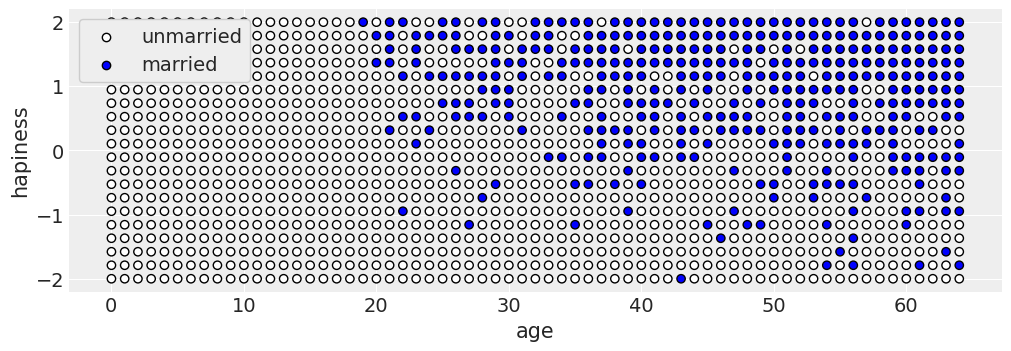

In [27]:
# Figure 6.4
fig, ax = plt.subplots(figsize=[10, 3.4])

colors = np.array(["w"] * popn.shape[0])
colors[popn.married] = "b"
ax.scatter(popn.age, popn.happiness, edgecolor="k", color=colors)

ax.scatter([], [], edgecolor="k", color="w", label="unmarried")
ax.scatter([], [], edgecolor="k", color="b", label="married")
ax.legend(loc="upper left", framealpha=1, frameon=True)

ax.set_xlabel("age")
ax.set_ylabel("hapiness");

#### Code 6.22

In [28]:
adults = popn.loc[popn.age > 17].copy()
adults.loc[:, "A"] = (adults["age"].copy() - 18) / (65 - 18)

#### Code 6.23

In [29]:
mid = adults.loc[:, "married"].astype(int).values

with pm.Model() as m_6_9:
    a = pm.Normal("a", 0, 1, shape=2)
    bA = pm.Normal("bA", 0, 2)

    mu = a[mid] + bA * adults.A.values
    sigma = pm.Exponential("sigma", 1)

    happiness = pm.Normal("happiness", mu, sigma, observed=adults.happiness.values)

    idata_6_9 = pm.sample(1000)

az.summary(idata_6_9, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.23,0.06,-0.32,-0.12,0.0,0.0,2002.16,2181.01,1.0
a[1],1.27,0.09,1.14,1.41,0.0,0.0,1985.37,2374.04,1.0
bA,-0.71,0.12,-0.88,-0.52,0.0,0.0,1758.74,1958.80,1.0
sigma,1.00,0.02,0.96,1.03,0.0,0.0,2892.99,2480.06,1.0


#### Code 6.24

In [30]:
with pm.Model() as m6_10:
    a = pm.Normal("a", 0, 1)
    bA = pm.Normal("bA", 0, 2)

    mu = a + bA * adults.A.values
    sigma = pm.Exponential("sigma", 1)

    happiness = pm.Normal("happiness", mu, sigma, observed=adults.happiness.values)

    idata_6_10 = pm.sample(1000)

az.summary(idata_6_10, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.00,0.08,-0.12,0.13,0.0,0.0,1986.41,2174.41,1.0
bA,-0.00,0.14,-0.23,0.22,0.0,0.0,1999.62,2242.52,1.0
sigma,1.22,0.03,1.17,1.26,0.0,0.0,2310.07,2076.17,1.0


#### Code 6.25

In [31]:
N = 200  # number of of grandparent-parent-child triads
b_GP = 1  # direct effect of G on P
b_GC = 0  # direct effect of G on C
b_PC = 1  # direct effect of P on C
b_U = 2  # direct effect of U on P and C

#### Code 6.26

In [32]:
U = 2 * np.random.binomial(1, 0.5, N) - 1
G = np.random.normal(size=N)
P = np.random.normal(b_GP * G + b_U * U)
C = np.random.normal(b_PC * P + b_GC * G + b_U * U)
d = pd.DataFrame.from_dict({"C": C, "P": P, "G": G, "U": U})

Text(0, 0.5, 'grandchild education (C)')

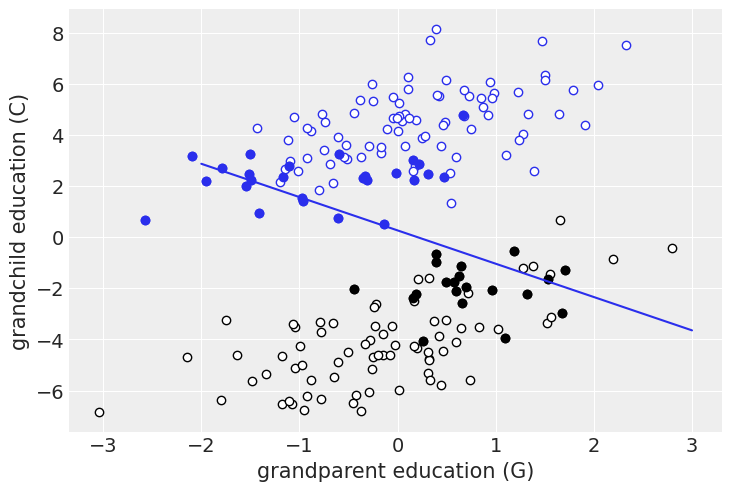

In [33]:
# Figure 6.5

# grandparent education
bad = U < 0
good = ~bad
plt.scatter(G[good], C[good], color="w", lw=1, edgecolor="C0")
plt.scatter(G[bad], C[bad], color="w", lw=1, edgecolor="k")

# parents with similar education
eP = (P > -1) & (P < 1)
plt.scatter(G[good & eP], C[good & eP], color="C0", lw=1, edgecolor="C0")
plt.scatter(G[bad & eP], C[bad & eP], color="k", lw=1, edgecolor="k")


p = np.polyfit(G[eP], C[eP], 1)
xn = np.array([-2, 3])
plt.plot(xn, np.polyval(p, xn))

plt.xlabel("grandparent education (G)")
plt.ylabel("grandchild education (C)")

#### Code 6.27

In [34]:
with pm.Model() as m_6_11:
    a = pm.Normal("a", 0, 1)
    p_PC = pm.Normal("b_PC", 0, 1)
    p_GC = pm.Normal("b_GC", 0, 1)

    mu = a + p_PC * d.P.values + p_GC * d.G.values
    sigma = pm.Exponential("sigma", 1)

    pC = pm.Normal("C", mu, sigma, observed=d.C.values)

    idata_6_11 = pm.sample()

az.summary(idata_6_11, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b_PC, b_GC, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.0,0.09,-0.14,0.15,0.0,0.0,5305.76,3373.38,1.0
b_PC,1.8,0.04,1.73,1.86,0.0,0.0,4521.91,3243.97,1.0
b_GC,-0.8,0.10,-0.97,-0.64,0.0,0.0,4511.45,3449.91,1.0
sigma,1.3,0.07,1.19,1.40,0.0,0.0,4342.12,2979.25,1.0


#### Code 6.28

In [35]:
with pm.Model() as m_6_12:
    a = pm.Normal("a", 0, 1)
    p_PC = pm.Normal("b_PC", 0, 1)
    p_GC = pm.Normal("b_GC", 0, 1)
    p_U = pm.Normal("b_U", 0, 1)

    mu = a + p_PC * d.P.values + p_GC * d.G.values + p_U * d.U.values
    sigma = pm.Exponential("sigma", 1)

    pC = pm.Normal("C", mu, sigma, observed=d.C.values)

    idata_6_12 = pm.sample()

az.summary(idata_6_12, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b_PC, b_GC, b_U, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 52 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.02,0.06,-0.07,0.13,0.0,0.0,4584.80,3222.52,1.0
b_PC,0.98,0.06,0.88,1.09,0.0,0.0,1535.12,2036.88,1.0
b_GC,0.05,0.09,-0.09,0.20,0.0,0.0,1800.31,2084.36,1.0
b_U,2.00,0.14,1.78,2.22,0.0,0.0,1618.03,2136.61,1.0
sigma,0.89,0.05,0.82,0.97,0.0,0.0,3732.14,2810.98,1.0


#### Code 6.29

Credit [ksachdeva](https://ksachdeva.github.io/rethinking-tensorflow-probability/)

In [36]:
dag_6_1 = CausalGraphicalModel(
    nodes=["X", "Y", "C", "U", "B", "A"],
    edges=[
        ("X", "Y"),
        ("U", "X"),
        ("A", "U"),
        ("A", "C"),
        ("C", "Y"),
        ("U", "B"),
        ("C", "B"),
    ],
)
all_adjustment_sets = dag_6_1.get_all_backdoor_adjustment_sets("X", "Y")
for s in all_adjustment_sets:
    if all(not t.issubset(s) for t in all_adjustment_sets if t != s):
        if s != {"U"}:
            print(s)

frozenset({'A'})
frozenset({'C'})


#### Code 6.30

Credit [ksachdeva](https://ksachdeva.github.io/rethinking-tensorflow-probability/)

In [37]:
dag_6_2 = CausalGraphicalModel(
    nodes=["S", "A", "D", "M", "W"],
    edges=[
        ("S", "A"),
        ("A", "D"),
        ("S", "M"),
        ("M", "D"),
        ("S", "W"),
        ("W", "D"),
        ("A", "M"),
    ],
)
all_adjustment_sets = dag_6_2.get_all_backdoor_adjustment_sets("W", "D")
for s in all_adjustment_sets:
    if all(not t.issubset(s) for t in all_adjustment_sets if t != s):
        print(s)

frozenset({'S'})
frozenset({'A', 'M'})


#### Code 6.31

Credit [ksachdeva](https://ksachdeva.github.io/rethinking-tensorflow-probability/)

In [38]:
all_independencies = dag_6_2.get_all_independence_relationships()
for s in all_independencies:
    if all(
        t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
        for t in all_independencies
        if t != s
    ):
        print(s)

('W', 'A', {'S'})
('W', 'M', {'S'})
('D', 'S', {'W', 'A', 'M'})


In [39]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sat Jan 06 2024

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.19.0

daft      : 0.1.2
numpy     : 1.26.3
seaborn   : 0.12.2
arviz     : 0.17.0
pandas    : 2.1.4
matplotlib: 3.8.2
scipy     : 1.11.4
pymc      : 5.10.3

Watermark: 2.4.3

